# PCA: Intel Images: VGG19

Using the Intel Images dataset, we will read the entire set of data files into memory as thier grayscale variants (in order to reduce dataset hashing time), then utilize the a custom hashing function of which generates a set of fixed length binary strings, each representing a different potential locality-sensifive hash of the image. The no preprocessing variant utilizes 150x150x3 images --> 67,500 features. The small grayscale variant utilizes 75x75x1 images --> 5,625 features. For the PCA, 1,024 components (32x32) is chosen instead, since 32x32 is the smallest possible dimensions which will be accepted accoss all model architectures (allowing this value to be consistent across all experiments).  In order to accomodate a model with the same size using the different preprocessing scheme. Each image is subject to a Standard Scaler saling before the components are extracted. 

It is hypothesized that this preprocessing may not yield any benefit when training on a convolutional neural network, as it will not see benefits from the convolutions, since components are ordered by significance rather than physical 2D location.

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`sklearn.decomposition.PCA`** used for principle component analysis. It was decided that the library implementation should be used instead of an application-specific optimized implementation in order to better reflect the general usage case rather than fringe usages. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow            import keras
from sklearn.utils         import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from timeit                import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Intel_Images/'
training_subdir = 'seg_train/seg_train/'
testing_subdir  = 'seg_test/seg_test/'
data_classes    = os.listdir( data_root_dir + training_subdir )
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Intel_Images/seg_train/seg_train/buildings/0.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10006.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/1001.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10014.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10018.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10029.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10032.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10056.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/1009.jpg', 'Dataset/Intel_Images/seg_train/seg_train/buildings/10113.jpg']

Testing Set: 
['Dataset/Intel_Images/seg_test/seg_test/buildings/20057.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20060.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20061.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20064.jpg', 'Dataset/Intel_Images/seg_test/seg_test/buildings/20073.jpg', 'Dataset/Intel_Images/seg

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. For the Intel Images dataset, all images are exactly `150x150`. As specified at the start of this notebook, due to the model architectures experimented with for this project, the smallest possible hash size which can be utilized consistently across the experimented architectures is 32x32. However, that `32x32` is not extracted at the time of reading the dataset. Rather, it is computed in future cells. For now, `150x150` is read into memory in order to be consistent with the LSH and unprocessed variants. We keep the read images as 8-bit integers without regularization since we will be performing min-max scaling later in the hashing step. We read the images in as their grayscale variants since color information is lost during the component extraction process, and it improves the overhead time for this processing step.

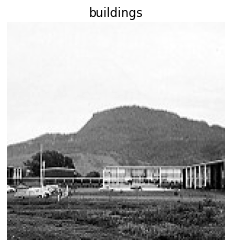

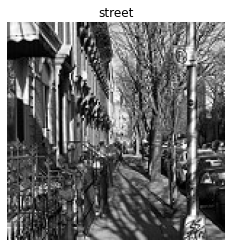

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (150,150,1): a 150x150 grayscale image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (RGB=3)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(150,150,1) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0]*desired_shape[1]*desired_shape[2] ) , dtype=np.float32 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i].split( '/' )[4]
        X[i] = cv2.resize( 
                    cv2.imread( file_list[i] , cv2.IMREAD_GRAYSCALE ), 
                    ( desired_shape[0] , desired_shape[1] ) 
                ).flatten( )  # read as rgb instead of bgr
        
    # === Return Results === #
    return X , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx , shape=(150,150,1) ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx].reshape(shape) , cmap='gray' )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

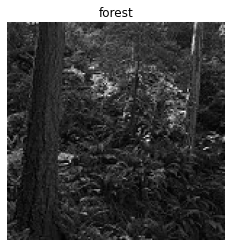

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )


# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## Scale the Dataset

In order for PCA to achieve meaningful results, the dataset must be scaled to have a scaled mean and stdev in order to determine which features most significantly affect the variance.

In [5]:
# === Start Timer === #
start = default_timer( )

# === Fit the Scaler === #
ss    = StandardScaler( )
ss.fit( X_train )

# === Transform Datasets === #
X_train = ss.transform( X_train )
X_test  = ss.transform( X_test  )

# === Stop Timer and Log === #
end   = default_timer( )
times.append( { 'Event': 'Standardize' , 'Time (sec)': end - start } )

## PCA

Using the sklearn library implementation of principle component analysis, we will fit the PCA object to our unprocessed training dataset in order to extract the 6,400 most important features of the dataset. This allows us to use the same number of features as the small grayscale implementation.

In [6]:
# === Start the Timer === #
start = default_timer( )

# === Fit a PCA Object to the Training Data === #
dim = 32
pca = PCA( n_components=dim*dim )
pca.fit( X_train )

# === Transform the Datasets === #
X_train = pca.transform( X_train )
X_test  = pca.transform( X_test  )

# === Reshape to Use Convolution === #
X_train = X_train.reshape( X_train.shape[0] , dim , dim , 1 )
X_test  = X_test.reshape(  X_test.shape[0]  , dim , dim , 1 )

# === Stop the Timer and Log === #
end = default_timer( )
times.append( { 'Event': 'PCA' , 'Time (sec)': end - start } )

# === Show the New Shape of the Data === #
X_train.shape

(14034, 32, 32, 1)

In [7]:
print(times[-1])

{'Event': 'PCA', 'Time (sec)': 27.534861999999997}


## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having multiple class categories, we will translate the possible classes to an integer valuea. 

    Buildings --> 0
    Forest --> 1
    Glacier --> 2
    Mountain --> 3
    Sea --> 4
    Street --> 5

Finally, the builtin keras functions `keras.utils.to_categorical()` is used to translate the numbered classes into categorical representation for use in the keras model whose output is determined by softmax. This translation is performed against both the training and validation labels.

In [8]:
# === Key to Translate in Either Direction
label_keys = {
    'buildings' : 0,
    'forest'    : 1,
    'glacier'   : 2,
    'mountain'  : 3,
    'sea'       : 4,
    'street'    : 5,
    0           : 'buildings',
    1           : 'forest',
    2           : 'glacier',
    3           : 'mountain',
    4           : 'sea',
    5           : 'street'
}

# === Iteratively Translate Labels === #
for c in data_classes:
    y_train[y_train==c] = label_keys[c]
    y_test[y_test==c]   = label_keys[c]

# === Update Data Types === #
y_train = y_train.astype( X_train.dtype )
y_test  = y_test.astype( X_test.dtype )
y_train = keras.utils.to_categorical( y_train )
y_test  = keras.utils.to_categorical( y_test )

# === Prove Success === #
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

## Create Layers for Model

We will be using a convolutional neural network, whose layers are specified to resemble the VGG19 model architecture. Consisting of 5 convolution blocks: 2x64, 2x128, 4x256, 4x512, 4x512. Each convolution block has a 2x2 pooling layer at the end of the block. After the five convolution blocks, the model is flattened, connected to a 1024 depth dense layer, then a dropout of 0.3, then a 64 depth dense layer, and finally a 1-depth dense layer for output. the ReLU activation function is used for all relevant layers with the exception of the output layer, which uses the softmax activation since this is a multi-class classification problem. 

In [9]:
model_layers = [
    keras.Input( shape=X_train[0].shape , name='Input_Layer' ),
    
    keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_1' , padding='same' ),
    keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_2' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_1_Pooling' ),
    
    keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_1' , padding='same' ),
    keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_2' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_2_Pooling' ),
    
    keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_1' , padding='same' ),
    keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_2' , padding='same' ),
    keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_3' , padding='same' ),
    keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_4' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_3_Pooling' ),
    
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_1' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_2' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_3' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_4' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_4_Pooling' ),
    
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_1' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_2' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_3' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_4' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_5_Pooling' ),
    
    keras.layers.Flatten( ),
    
    keras.layers.Dense( 1024 , activation='relu' ),
    keras.layers.Dropout( 0.3 ),
    
    keras.layers.Dense( 64 , activation='relu' ),
    keras.layers.Dropout( 0.3 ),
    
    keras.layers.Dense( len(data_classes) , activation='softmax' )
]

## Construct the Model

First we will use the list of layers we defined as input to the constructor of a `keras.Sequential` object, which will contain our model. After the model initializes with our specified layers, we will define a custom optimizer -- a variant of the built-in `adam` optimizer with a lower learning rate (which has been tuned over several runs of the program to determine one which produces stable results, as the default would over fit too quickly). Finally, we compile the model to our specifications and summarize the model to show that it compiled successfully. 

In [10]:
# === Construct Model from Layers === #
model = keras.Sequential( layers=model_layers )

# === Compile the Model with Custom Learning Rate === #
epochs    = 25
rate      = len(model_layers) / model.count_params( )
decay     = rate / epochs
optimizer = keras.optimizers.Adam( lr=rate , decay=decay )
model.compile( loss="categorical_crossentropy" , optimizer=optimizer , metrics=["accuracy"] )

# === Summary to Show Successfil Compilation === #
model.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
Conv_1_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
Conv_1_Pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
Conv_2_2 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
Conv_2_Pooling (MaxPooling2D (None, 8, 8, 128)         0         
_________________________________________________________________
Conv_3_1 (Conv2D)            (None, 8, 8, 256)         2

## Train the Model

Now that our model is compiled and our dataset is in memory, it's time to train the model. The process is relatively straightforward. We train for 25 epochs (the results of several prior tests determined that the model would coverge most commonly by the 25th epoch). We also opted to use a batch size of 16 in order to balance the training time with model performance. 

In [11]:
# === Train the Model to Our Data for 25 Epochs === #
start = default_timer( )
history = model.fit( X_train,
                     y_train,
                     epochs=epochs,
                     batch_size=16,
                     validation_data=( X_test , y_test ) )
end = default_timer( )
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

# === Extract History Values for Later Plotting === #
history_dict = history.history

Train on 14034 samples, validate on 3000 samples
Epoch 1/25
14034/14034 [==============================] - 23s 2ms/sample - loss: 1.7339 - accuracy: 0.2386 - val_loss: 1.6755 - val_accuracy: 0.2500
Epoch 2/25
14034/14034 [==============================] - 19s 1ms/sample - loss: 1.6150 - accuracy: 0.2896 - val_loss: 1.6362 - val_accuracy: 0.2893
Epoch 3/25
14034/14034 [==============================] - 19s 1ms/sample - loss: 1.5916 - accuracy: 0.3051 - val_loss: 1.5863 - val_accuracy: 0.3197
Epoch 4/25
14034/14034 [==============================] - 19s 1ms/sample - loss: 1.5687 - accuracy: 0.3229 - val_loss: 1.5717 - val_accuracy: 0.3223
Epoch 5/25
14034/14034 [==============================] - 19s 1ms/sample - loss: 1.5503 - accuracy: 0.3291 - val_loss: 1.6141 - val_accuracy: 0.2863
Epoch 6/25
14034/14034 [==============================] - 21s 2ms/sample - loss: 1.5288 - accuracy: 0.3391 - val_loss: 1.5183 - val_accuracy: 0.3480
Epoch 7/25
14034/14034 [==============================] -

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

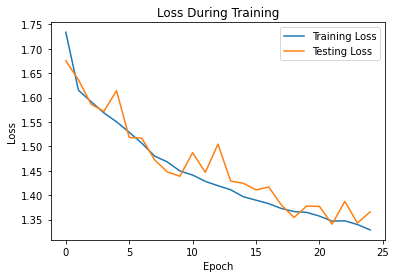

In [12]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

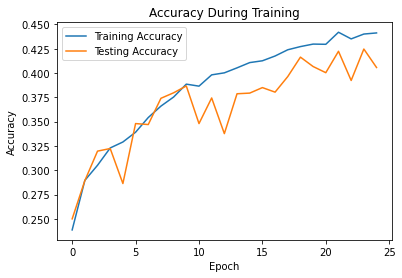

In [13]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [14]:
# === Save for Future Evaluation === #
model.save( 'PCA_Results/vgg19_intel_model.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [15]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 12.2336s
Standardize: 5.0831s
PCA: 27.5349s
Training: 515.6149s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [16]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'PCA_Results/vgg19_intel_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,12.233581
1,Standardize,5.083058
2,PCA,27.534862
3,Training,515.614892


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [17]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'PCA_Results/vgg19_intel_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.238635,0.250000,1.733858,1.675547
1,2,0.289582,0.289333,1.614968,1.636162
2,3,0.305116,0.319667,1.591583,1.586286
3,4,0.322930,0.322333,1.568727,1.571715
4,5,0.329058,0.286333,1.550323,1.614054
5,6,0.339105,0.348000,1.528800,1.518339
6,7,0.354211,0.347000,1.506394,1.516713
7,8,0.365968,0.374000,1.480220,1.472440
8,9,0.375303,0.379667,1.468155,1.447745
9,10,0.388556,0.386667,1.449562,1.438758


## Experiment: Inference Time

Now that the model has been fully trained, and all preprocessing techniques timed for the training process, we will now evaluate the individual usage cost of this method when performing inference on 1, 10, 100, and 1000 images. Each experiment will be done using a subset of the original testing files, and include the end-to-end process: reading the file, preprocessing the image, and performing inference on the image(s). 

In [18]:
# ================================================================================
# FUNCTION: get_inference_time( n , model , file_list )
# ================================================================================
#
# Input:
#   - n: the number of files to perform inference on
#   - model: the trained model on which to perform the inference
#   - file_list: the list of file paths on which a subset will be inferenced from
#   - ss: StandardScaler object fit to the training dataset
#   - pca: PCA object fit to the training dataset
#   - dim: expected (square) input dimensions for the model
#
# Output:
#   - total time (in seconds) to perform all reading/preprocessing/inferencing
#
# Task:
#   1. extract a length n subset of the file_list given
#   2. read the n images into memory
#   3. perform any necessary additional preprocessing
#   4. perform inference on the files using the given model
#   5. return the time it took to perform the entire function
#
# ================================================================================
def get_inference_time( n , model , file_list , ss , pca , dim ):
    
    # === Start the Timer === #
    start = default_timer( )
    
    # === Create Set of N Files === #
    files = np.random.choice( file_list , n )
    
    # === Read the Files Into Memory === #
    X , y = files_to_Xy( files )
    
    # === Additional Processing Before Inference (Scale & Components) === #
    X = ss.transform( X )
    X = pca.transform( X )
    X = X.reshape( X.shape[0] , dim , dim , 1 )
    
    # === Inference === #
    pred = model.predict( X )
    
    # === End Timer === #
    end = default_timer( )
    return end - start
    
    
inf_1x    = get_inference_time(    1 , model , testing_files , ss , pca , dim )
inf_10x   = get_inference_time(   10 , model , testing_files , ss , pca , dim )
inf_100x  = get_inference_time(  100 , model , testing_files , ss , pca , dim )
inf_1000x = get_inference_time( 1000 , model , testing_files , ss , pca , dim )

## Create Output CSV  for Inference Times

Now that the inference times have been properly computed, we will format them into a CSV file for use in a different file during results aggregation. 

In [19]:
# === Construct Formatted Dict === #
data = {
    'Dataset'                : 'Intel Images',
    'Model'                  : 'VGG19',
    'Method'                 : 'PCA',
    '1x Inference (Sec)'     : inf_1x,
    '10x Inference (Sec)'    : inf_10x,
    '100x Inference (Sec)'   : inf_100x,
    '1,000x Inference (Sec)' : inf_1000x,
}

# === Convert to DataFrame === #
data = pd.DataFrame( [ data ] )

# === Save DataFrame === #
data.to_csv( 'PCA_Results/vgg19_intel_inference.csv' , index=False )
data

,Dataset,Model,Method,1x Inference (Sec),10x Inference (Sec),100x Inference (Sec),"1,000x Inference (Sec)"
0,Intel Images,VGG19,PCA,0.399005,0.32358,0.703694,1.254572
